In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
import optuna

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history
from library.XGBoost import XGBoost_creator
from library.LightGBM import LightGBM_creator
from library.CatBoost import CatBoost_creator
from library.Random_Forest import RandomForest_creator
from library.Extra_Trees import ExtraTrees_creator
from library.StackingCV_Scheme3 import optimize_base, stratified_data, runall_LR, runall_RidgeR, stackingCV_creator, \
    correlation_plot, vif, rank_importance, month_param

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### transform data by base learner

In [2]:
def transform_train(train_data, mode, base_param, cv):
    
    num_set = len(train_data.keys())
    month_list = list(base_param.keys())
    model_list = list(base_param[month_list[0]].keys())
    set_dict = {} 
    for i in tqdm(range(num_set)):
        
        train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train_data[f'set{i}'], cv = cv)
        all_month = pd.DataFrame()
        for month in tqdm(month_list):    
            
            all_cv = pd.DataFrame()
            for j in range(cv):
                
                model_predict = pd.DataFrame()
                if mode == 'C':

                    if 'XGBoost' in model_list:                     
                        clf = XGBClassifier(**base_param[month]['XGBoost'][f'set{i}'], n_jobs = -1)
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'X_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)

                    if 'LightGBM' in model_list:                        
                        clf = LGBMClassifier(**base_param[month]['LightGBM'][f'set{i}'])
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'L_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'CatBoost' in model_list:
                        clf = CatBoostClassifier(**base_param[month]['CatBoost'][f'set{i}'])
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'C_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'RandomForest' in model_list:
                        clf = RandomForestClassifier(**base_param[month]['RandomForest'][f'set{i}'])
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'R_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'ExtraTrees' in model_list:
                        clf = ExtraTreesClassifier(**base_param[month]['ExtraTrees'][f'set{i}'])
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'E_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                elif mode == 'R':
                    
                    if 'XGBoost' in model_list:
                        reg = XGBRegressor(**base_param[month]['XGBoost'][f'set{i}'], n_jobs = -1)
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'X_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)

                    if 'LightGBM' in model_list:
                        reg = LGBMRegressor(**base_param[month]['LightGBM'][f'set{i}'])
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'L_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'CatBoost' in model_list:
                        reg = CatBoostRegressor(**base_param[month]['CatBoost'][f'set{i}'])
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'C_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'RandomForest' in model_list:
                        reg = RandomForestRegressor(**base_param[month]['RandomForest'][f'set{i}'])
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'R_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                    
                    if 'ExtraTrees' in model_list:
                        reg = ExtraTreesRegressor(**base_param[month]['ExtraTrees'][f'set{i}'])
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'E_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                test_label = valid_y_dict[j].reset_index(drop = True)
                done_cv = pd.concat([model_predict, test_label], axis = 1)
                all_cv = pd.concat([all_cv, done_cv], axis = 0)                
        
            all_month = pd.concat([all_month, all_cv], axis = 1)
            if month != month_list[-1]:
                all_month = all_month.drop(columns = 'GB')
        
        set_dict[f'set{i}'] = all_month
    
    return set_dict


def transform_test(train_data, test_data, mode, base_param):
    
    month_list = list(base_param.keys())
    model_list = list(base_param[month_list[0]].keys())
    num_set = len(train_data[month_list[0]].keys())
    test_dict = {}
    for i in tqdm(range(num_set)):
        
        month_test = pd.DataFrame()
        for month in tqdm(month_list):
            
            select_test = train_col(train_data[month][f'set{i}'], test_data)
            train_x, train_y, test_x, test_y = label_divide(train_data[month][f'set{i}'], select_test, train_only = False)
            model_predict = pd.DataFrame()
            if mode == 'C':

                if 'XGBoost' in model_list:
                    clf = XGBClassifier(**base_param[month]['XGBoost'][f'set{i}'], n_jobs = -1)
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'X_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    clf = LGBMClassifier(**base_param[month]['LightGBM'][f'set{i}'])
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'L_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    clf = CatBoostClassifier(**base_param[month]['CatBoost'][f'set{i}'])
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'C_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    clf = RandomForestClassifier(**base_param[month]['RandomForest'][f'set{i}'])
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'R_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    clf = ExtraTreesClassifier(**base_param[month]['ExtraTrees'][f'set{i}'])
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'E_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            elif mode == 'R':

                if 'XGBoost' in model_list:
                    reg = XGBRegressor(**base_param[month]['XGBoost'][f'set{i}'], n_jobs = -1)
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'X_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    reg = LGBMRegressor(**base_param[month]['LightGBM'][f'set{i}'])
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'L_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    reg = CatBoostRegressor(**base_param[month]['CatBoost'][f'set{i}'])
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'C_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    reg = RandomForestRegressor(**base_param[month]['RandomForest'][f'set{i}'])
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'R_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    reg = ExtraTreesRegressor(**base_param[month]['ExtraTrees'][f'set{i}'])
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'E_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            month_test = pd.concat([month_test, model_predict], axis = 1)
        month_done = pd.concat([month_test, test_y], axis = 1)
        test_dict[f'set{i}'] = month_done
        
    return test_dict

### optuna

In [ ]:
def stackingCV_creator(train_data, mode, num_valid = 3) :
    
    def objective(trial) :
        # hyperparameters randomize setting
        if mode == 'C' :
            meta_learner = 'Logistic Regression'
            
            if meta_learner == 'Logistic Regression' :      
                param = {
                    'solver': 'lbfgs',
                    'C': trial.suggest_categorical('C', [100, 10 ,1 ,0.1, 0.01]),
                    'penalty': trial.suggest_categorical('penalty', ['none', 'l2']),
                    'n_jobs': -1
                }

            elif meta_learner == 'Extra Trees' :
                param = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 500, step = 100),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 32, step = 5),
                    'max_depth': trial.suggest_int('max_depth', 3, 21, step = 3),
                    'n_jobs': -1
                }     

        elif mode == 'R' :
            meta_learner = 'RidgeCV'
            
            if meta_learner == 'RidgeCV' :
                param = {
                    'alpha': trial.suggest_float('alpha', 0, 1, step = 0.1)
                }
            
            elif meta_learner == 'Extra Trees' :
                param = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 500, step = 100),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 32, step = 5),
                    'max_depth': trial.suggest_int('max_depth', 3, 21, step = 3),
                    'n_jobs': -1
                }
        
        # objective function
        result_list = []
        for i in range(num_valid):

            train_x, train_y = label_divide(train_data, None, 'GB', train_only = True)
            train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.25)

            if mode == 'C':
                result, _ = LR(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                aging = table['Aging Rate']
                result_list.append(recall - 0.1*aging)

            elif mode == 'R':
                result, _ = RidgeR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)
    
    return objective

## 

### loading training & testing data

In [5]:
### training data ### 
training_month = range(4, 7)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 4:

Dimension of dataset 0 : (57743, 99)  balance ratio: 433.0
Dimension of dataset 1 : (2600, 99)  balance ratio: 1.0
Dimension of dataset 2 : (3066, 99)  balance ratio: 1.0
Dimension of dataset 3 : (2920, 99)  balance ratio: 1.0
Dimension of dataset 4 : (2660, 99)  balance ratio: 1.0
Dimension of dataset 5 : (2643, 99)  balance ratio: 1.0
Dimension of dataset 6 : (2880, 99)  balance ratio: 1.0
Dimension of dataset 7 : (2660, 99)  balance ratio: 1.0
Dimension of dataset 8 : (2660, 99)  balance ratio: 1.0
Dimension of dataset 9 : (1463, 99)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 5:

Dimension of dataset 0 : (48649, 93)  balance ratio: 415.0
Dimension of dataset 1 : (2316, 93)  balance ratio: 1.0
Dimension of dataset 2 : (3178, 93)  balance ratio: 1.0
Dimension of dataset 3 : (2566, 93)  balance ratio: 1.0
Dimension of dataset 4 : (2338, 93)  balance ratio: 1.0
Dimension of dataset 5 : (2348, 93)  balance ratio: 1.0
Dimension of

## base learner

### optimize the base learners by one-month data

In [ ]:
##### for both training & testing data transformation ##### 
base_param_monthC = optimize_base(num_set = 10, 
                                  train_data = data_dict, 
                                  mode = 'C', 
                                  TPE_multi = False, 
                                  base_list = ['RandomForest', 'LightGBM'],
                                  iter_list = [50, 200],
                                  filename = 'runhist_array_m1m6_m7_3criteria')
 
# base_param_monthR = optimize_base(num_set = 10, 
#                                   train_data = data_dict, 
#                                   mode = 'R', 
#                                   TPE_multi = True, 
#                                   base_list = ['RandomForest', 'LightGBM'],
#                                   iter_list = [50, 200],
#                                   filename = 'runhist_array_4criteria_m2m5')

In [11]:
##### 'OR' by loading from stackingCV scheme 3 #####
base_param_monthC = month_param(num_set = 10, 
                                date = '20211123', 
                                month_list = list(range(4, 7)), 
                                model_list = ['RandomForest', 'LightGBM'], 
                                iter_list = [50, 200], 
                                filename = 'runhist_array_m1m6_m7_3criteria', 
                                mode = 'C', 
                                TPE_multi = True)

# base_param_monthR = month_param(num_set = 10, 
#                                 date = '20211019', 
#                                 month_list = [2, 3, 4], 
#                                 model_list = ['XGBoost', 'LightGBM'], 
#                                 iter_list = [200, 200], 
#                                 filename = 'runhist_array_4criteria_m2m5', 
#                                 mode = 'R', 
#                                 TPE_multi = True)

### data transform for scheme 2

In [ ]:
train_firstC = transform_train(run_train,  
                               mode = 'C', 
                               base_param = base_param_monthC, 
                               cv = 5)
test_firstC = transform_test(data_dict,
                             run_test, 
                             mode = 'C', 
                             base_param = base_param_monthC)
train_firstC_x, train_firstC_y = train_set(train_firstC, num_set = 10)
test_firstC_x, test_firstC_y = train_set(test_firstC, num_set = 10) 

# train_firstR = transform_train(run_train, 
#                                mode = 'R', 
#                                base_param = base_param_monthR, 
#                                cv = 5)
# test_firstR = transform_test(data_dict, 
#                              run_test, 
#                              mode = 'R', 
#                              base_param = base_param_monthR)
# train_firstR_x, train_firstR_y = train_set(train_firstR, num_set = 10)
# test_firstR_x, test_firstR_y = train_set(test_firstR, num_set = 10) 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## meta learner

### searching for best hyperparameters

In [ ]:
best_paramC, _ = all_optuna(num_set = 10, 
                            all_data = train_firstC, 
                            mode = 'C', 
                            TPE_multi = True, 
                            n_iter = 10,
                            filename = f'runhist_array_m1m6_m7_3criteria_StackingCV2',
                            creator = stackingCV_creator
)

# best_paramR, _ = all_optuna(num_set = 10, 
#                             all_data = train_firstR, 
#                             mode = 'R', 
#                             TPE_multi = True, 
#                             n_iter = 10,
#                             filename = f'runhist_array_4criteria_m2m5_StackingCV2',
#                             creator = stackingCV_creator
# )

### feature selection by feature importance

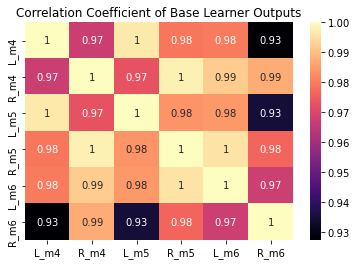

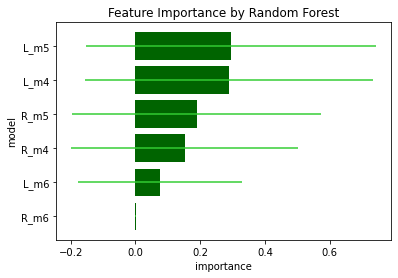

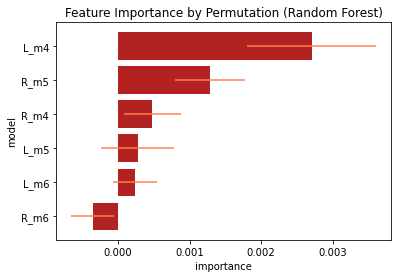

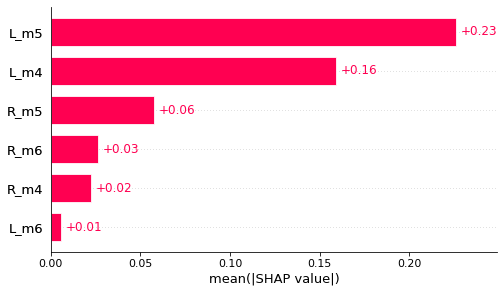

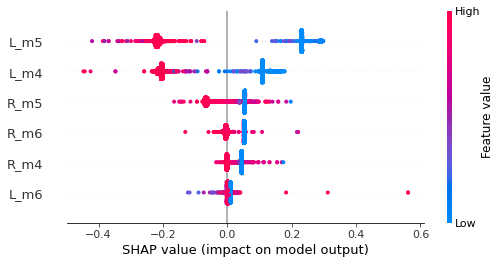

,GLM,forest,permutation,SHAP,total_rank
L_m4,3.0,2.0,1.0,2.0,1.0
R_m5,1.0,3.0,2.0,3.0,2.0
L_m5,4.0,1.0,4.0,1.0,3.0
R_m4,2.0,4.0,3.0,5.0,4.0
R_m6,5.0,6.0,6.0,4.0,5.0
L_m6,6.0,5.0,5.0,6.0,6.0


In [8]:
rank_importance(train_firstC['set7'], mode = 'C')

### classifier

  0%|          | 0/10 [00:00<?, ?it/s]


 Dataset 0:


invalid value encountered in double_scalars
invalid value encountered in double_scalars
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

 Dataset 1:
Precision: 0.0011426939008713042 
Recall: 0.21621621621621623 
Aging Rate: 0.1618990356820757

 Dataset 2:
Precision: 0.0009675119665953763 
Recall: 0.5135135135135135 
Aging Rate: 0.45413130448858774

 Dataset 3:
Precision: 0.0008214795278654503 
Recall: 0.5135135135135135 
Aging Rate: 0.5348611335938764

 Dataset 4:
Precision: 0.0008603383997705764 
Recall: 0.32432432432432434 
Aging Rate: 0.32254931433989315

 Dataset 5:
Precision: 0.0010791719807711174 
Recall: 0.2972972972972973 
Aging Rate: 0.2357144508937863

 Dataset 6:
Precision: 0.001188001188001188 
Recall: 0.43243243243243246 
Aging Rate: 0.3114492519020419

 Dataset 7:
Precision: 0.0009923175416133162 
Recall: 0.8378378378378378 
Aging Rate: 0.7224290636634831

 Dataset 8:
Precision: 0.0008145975887911372 
Recall: 0.13513513513513514 
Aging Rate: 0.1419420484240224

 Dataset 9:
Precision: 0.0011023439313065677 
Recall: 0.5135135135135135 
Aging Rate: 0.398584742039174

Setting penalty='none' will ignore the C and l1_ratio parameters


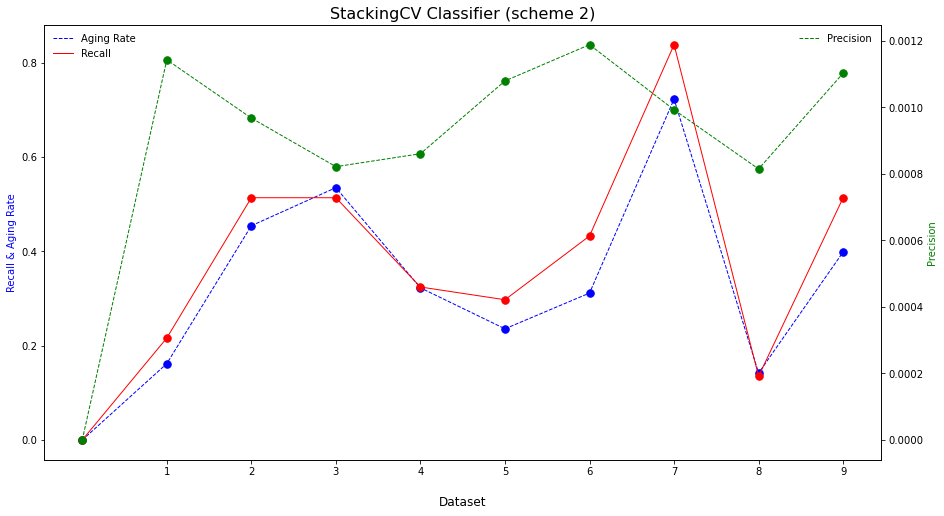

In [9]:
table_setC, coefC = runall_LR(10, train_firstC_x, test_firstC_x, train_firstC_y, test_firstC_y, best_paramC)
line_chart(table_setC, title = 'StackingCV Classifier (scheme 2)')

In [10]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,479.923077,230843.0,481.0,0.0,0.0,37.0,43206.0,0.000000,0.000000,0.000000,NaN,NaN
dataset 1,1.000000,4774.0,4774.0,8.0,6993.0,29.0,36213.0,0.001143,0.216216,0.161899,1.335500,0.183400
dataset 2,1.000000,6276.0,6276.0,19.0,19619.0,18.0,23587.0,0.000968,0.513514,0.454131,1.130760,0.388462
dataset 3,1.000000,5278.0,5278.0,19.0,23110.0,18.0,20096.0,0.000821,0.513514,0.534861,0.960088,0.000000
dataset 4,1.000000,4809.0,4809.0,12.0,13936.0,25.0,29270.0,0.000860,0.324324,0.322549,1.005503,0.225696
dataset 5,1.002501,4810.0,4798.0,11.0,10182.0,26.0,33024.0,0.001079,0.297297,0.235714,1.261260,0.242572
dataset 6,0.758675,4810.0,6340.0,16.0,13452.0,21.0,29754.0,0.001188,0.432432,0.311449,1.388452,0.376495
dataset 7,1.000000,4810.0,4810.0,31.0,31209.0,6.0,11997.0,0.000992,0.837838,0.722429,1.159751,0.645129
dataset 8,1.000000,4810.0,4810.0,5.0,6133.0,32.0,37073.0,0.000815,0.135135,0.141942,0.952044,0.000000
dataset 9,10.000000,4810.0,481.0,19.0,17217.0,18.0,25989.0,0.001102,0.513514,0.398585,1.288342,0.425101


### regressor

In [ ]:
pr_dict, table_setR, coefR = runall_RidgeR(10, train_firstR_x, test_firstR_x, train_firstR_y, test_firstR_y, 
                                           best_paramR, thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'StackingCV Regressor (scheme 2)')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
print(coefR)
table_setR

### export

In [ ]:
savedate = '20211123'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'StackingCV 2(m456)'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'StackingCV_2(m456)')